# HDSoC Waveform Packet Window Positions

For each waveform in each event, find which packet `window_position` values contributed to the waveform trace.


In [1]:
import os
import math
from collections import defaultdict, Counter

import ROOT as r
import matplotlib.pyplot as plt

print(r.gROOT.GetVersion())


6.36.04


In [2]:
BUILD_LIB_PATH = "../../build/lib"

libs_to_load = [
    "libanalysis_pipeline_core.so",
    "libunpacker_data_products_core.so",
    "libunpacker_data_products_nalu.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        r.gSystem.Load(path)
    else:
        print(f"Skipping missing library: {path}")


In [3]:
DATA_FILE = "../../output.root"
f = r.TFile.Open(DATA_FILE)
if not f or f.IsZombie():
    raise RuntimeError(f"Could not open {DATA_FILE}")

tree = f.Get("events")
if not tree:
    raise RuntimeError("Tree 'events' not found")

print(f"Entries: {tree.GetEntries()}")


Entries: 2559


In [4]:
def waveform_window_positions(evt, wf):
    ch = int(wf.channel_num)
    return [
        int(p.window_position)
        for p in evt.packets.packets
        if int(p.channel) == ch
    ]


In [5]:
# First: print one list of window positions for one waveform
event_index = 0
waveform_index = 0

tree.GetEntry(event_index)
evt = tree.nalu_event
wfs = list(evt.waveforms.waveforms)

if waveform_index >= len(wfs):
    raise IndexError(f"waveform_index={waveform_index} out of range for event {event_index}")

wf = wfs[waveform_index]
positions = waveform_window_positions(evt, wf)
print(f"Event {event_index}, waveform {waveform_index}, channel {int(wf.channel_num)}")
print("Window positions:", positions)


Event 0, waveform 0, channel 1
Window positions: [1, 2, 3, 4, 5, 6, 7, 8]


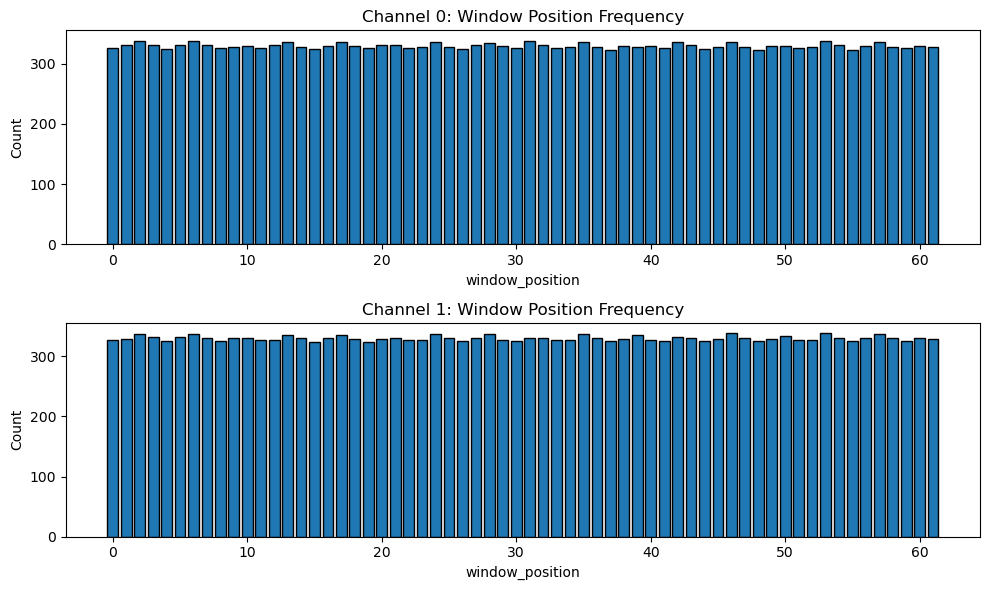

In [6]:
# Then: histogram of window position frequency across all events, one histogram per channel
window_pos_counts_by_channel = defaultdict(Counter)

for entry in range(tree.GetEntries()):
    tree.GetEntry(entry)
    evt = tree.nalu_event

    for wf in evt.waveforms.waveforms:
        ch = int(wf.channel_num)
        positions = waveform_window_positions(evt, wf)
        window_pos_counts_by_channel[ch].update(positions)

channels = sorted(window_pos_counts_by_channel.keys())
n_channels = len(channels)

fig, axes = plt.subplots(n_channels, 1, figsize=(10, 3 * n_channels), sharex=False)
if n_channels == 1:
    axes = [axes]

for ax, ch in zip(axes, channels):
    counter = window_pos_counts_by_channel[ch]
    xs = sorted(counter.keys())
    ys = [counter[x] for x in xs]

    ax.bar(xs, ys, width=0.8, edgecolor="black")
    ax.set_title(f"Channel {ch}: Window Position Frequency")
    ax.set_xlabel("window_position")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [7]:
f.Close()
